<a href="https://colab.research.google.com/github/howsam/Building-a-ChatGPT-like-Model-from-Scratch/blob/main/Train_GPT-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <font color='#FFE15D'><b>💎 Train GPT-2 on TinyStories Dataset </b></font><font color='#FF0B55'></font>

# 🔴 **Environment Setup**

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 20px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


## 🟠 `pip`

# 🔴 **Import**

In [ ]:
import os
import sys
import time
import math
import json
import yaml
import random
from tqdm import tqdm
from pprint import pprint
from itertools import cycle
from datetime import datetime
from termcolor import colored
from dataclasses import dataclass, asdict
from prettytable import PrettyTable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import load_dataset
from tokenizers import Tokenizer

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torchmetrics import MeanMetric

In [ ]:
import tokenizers
tokenizers.__version__

'0.19.1'

# 🔴 **Utils**

In [ ]:
def prepare_data(tokens, seq_len):
    # Trim tokens so that total length is divisible by seq_len
    n_tokens = (tokens.shape[0] // seq_len) * seq_len
    tokens = tokens[:n_tokens]
    # Reshape to 2D tensor
    return tokens.view(-1, seq_len)

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
# Benchmarking function
def calculate_time(model, x, num_runs=10):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(num_runs):
        model(x)
    torch.cuda.synchronize()
    return (time.time() - start) / num_runs

# 🔴 **Dataset**

In [ ]:
class TinyStoriesDataset(Dataset):

    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = prepare_data(data, seq_len+1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample.long()#[:-1], sample[1:]

# 🔴 **Model**

## 🟠 Multi Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.head_size = self.n_embd // self.n_head

        self.qkv_proj = nn.Linear(self.n_embd, 3*self.n_embd, bias=False)
        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)
        self.c_proj.residual = True

    def forward(self, x):
        B, T, C = x.shape
        # QKV linear
        q, k, v = self.qkv_proj(x).view(B, T, 3*self.n_head, self.head_size).transpose(1, 2).chunk(3, dim=-3)
        # Scaled Dot Product Attention using pytorch
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # Reshape and final projection
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

## 🟠 Feed Forward (MLP)

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.f_expnd = config.f_expnd

        self.up_proj = nn.Linear(self.n_embd, int(self.f_expnd*self.n_embd), bias=False)
        self.down_proj = nn.Linear(int(self.f_expnd*self.n_embd), self.n_embd, bias=False)
        self.down_proj.residual = True

    def forward(self, x):
        return self.down_proj(F.gelu(self.up_proj(x)))

## 🟠 Decoder Block

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        # Multi Head Attention
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.mha = MultiHeadAttention(config)
        # Feed Forward Neural Network
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

## 🟠 GPT

In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # Token embedding
        self.wpe = nn.Embedding(config.max_seq_len, config.n_embd) # Position embedding
        self.decoders = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]) # Decoders
        self.lnf = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Classifier
        self.lm_head.weight = self.wte.weight # Weight tying

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            if hasattr(module, 'residual'):
                std *= (2*self.config.n_layer)**-0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx):
        B, T = idx.shape
        # Token Embedding + Position Embedding
        x = self.wte(idx) + self.wpe(torch.arange(T, device=idx.device))
        # Decoders
        for decoder in self.decoders:
            x = decoder(x)
        # Classifier
        x = self.lnf(x)
        logits = self.lm_head(x)
        return logits

# 🔴 **Config**

In [ ]:
@dataclass
class DatasetConfig:
    train_path: str
    valid_path: str
    tokenizer_path: str
    batch_size: int = 32
    seq_len: int = 128


@dataclass
class GPTConfig:
    vocab_size: int = 50257
    max_seq_len: int = 1024
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    f_expnd: int = 4


@dataclass
class OptimizerConfig:
    max_lr: float = 3e-4
    betas: tuple = (0.9, 0.95)
    weight_decay: float = 0.1
    fused: bool = True
    warmup_steps: int = 256
    alpha: float = 0.1


@dataclass
class TrainConfig:
    seed: int = 42
    device: str = 'cuda'
    total_tokens: int = 100_000
    log_interval_tokens: int = 50_000
    log_dir: str = 'logs'
    run_name: str = 'gpt2_tinystories'


@dataclass
class GenerationConfig:
    prompts: list[str]
    T: float = 0.9
    max_seq_len: int = 128
    top_k: int = 10
    n_rep: int = 3
    seed: int = 42


@dataclass
class MasterConfig:
    data: DatasetConfig
    model: GPTConfig
    optimizer: OptimizerConfig
    train: TrainConfig
    generation: GenerationConfig

# 🔴 **Functions ⚙️**

## 🟠 Logger

In [ ]:
# Logger class for saving and plotting training logs
class Logger:
    """
    Manages training history logging, saving to disk, and plotting learning curves.
    """
    def __init__(self, log_dir='logs', run_name='default_run'):
        # Make dir
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_dir = os.path.join(log_dir, f"{run_name}_{timestamp}")
        os.makedirs(self.log_dir, exist_ok=False)
        # Create history dictionay
        self.history = {
            'train_loss': [],
            'valid_loss': [],
            'best_loss_valid': float('inf'),
            'seen_tokens': [],
            'elapsed_time': []
        }

    def log(self, train_loss, valid_loss, seen_tokens, elapsed_time=0):
        self.history['train_loss'].append(train_loss)
        self.history['valid_loss'].append(valid_loss)
        self.history['seen_tokens'].append(seen_tokens)
        self.history['elapsed_time'].append(elapsed_time)

    def save(self, model, optimizer):
        # Save history
        file_path = os.path.join(self.log_dir, 'loss_history.json')
        with open(file_path, 'w') as f:
            json.dump(self.history, f, indent=4)
        # Save best model and optimizer
        current_loss_valid = self.history['valid_loss'][-1]
        if current_loss_valid < self.history['best_loss_valid']:
            log = dict(model=model.state_dict(), optimizer=optimizer)
            torch.save(log, f'{self.log_dir}/best_model.pt')
            self.history['best_loss_valid'] = current_loss_valid
            print("✅ Model Saved!")
        self.plot()

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['seen_tokens'], self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['seen_tokens'], self.history['valid_loss'], label='Valid Loss')
        plt.xlabel('Seen Tokens')
        plt.ylabel('Loss')
        plt.title(f'Learning Curve')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(self.log_dir, 'learning_curve.png'))
        plt.show()

## 🟠 Train ➰

In [ ]:
# Trainer class to manage model training, evaluation and reporting
class LLMTrainer:
    """
    Trainer handles training loops, periodic evaluation, logging, and sample generation.
    """
    def __init__(self, model, optimizer, train_loader, valid_loader, tokenizer,
                 config, loss_fn=F.cross_entropy):

        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.tokenizer = tokenizer
        self.loss_fn = loss_fn
        self.config = config
        self.device = config.train.device

        self.seen_tokens = 0
        self.token_eval_counter = 0
        self.total_tokens = config.train.total_tokens
        self.log_interval_tokens = config.train.log_interval_tokens

        self.logger = Logger(log_dir=config.train.log_dir, run_name=config.train.run_name)
        self._print_config_summary()

        self.generation = config.generation

        # Save config as a yaml file
        with open(f'{self.logger.log_dir}/config.yaml', 'w') as f:
            yaml.dump(asdict(config), f, sort_keys=False, indent=4)

    def train(self):
        """
        Main training loop that stops when total token count is reached.
        """
        # Initial evaluation before any training
        initial_loss = self.evaluate()
        self.logger.log(initial_loss, initial_loss, 0)
        print(f"👶 [Initial] Train Loss (Untrained Model): {initial_loss:.4f}\n")

        loss_train = MeanMetric()
        self.model.train()
        train_iter = cycle(self.train_loader)

        step = 0
        total_steps = self.config.train.total_tokens // (self.config.data.batch_size*self.config.data.seq_len) + 1
        batches = 0
        start_time = time.time()
        total_time_elapsed = 0

        with tqdm(total=self.total_tokens, desc="Training", unit="t") as pbar:
            while self.seen_tokens < self.total_tokens:
                # Get inputs
                inputs = next(train_iter).to(self.device)

                # Forward pass
                logits = self.model(inputs[:, :-1])

                # Calculate loss
                loss = self.loss_fn(logits.view(-1, logits.shape[-1]), inputs[:, 1:].flatten())

                # Backward pass
                loss.backward()

                # Clip gradients
                nn.utils.clip_grad.clip_grad_norm_(self.model.parameters(), max_norm=1.)

                # Determine and set the learning rate for this iteration
                lr = get_lr(step, total_steps, self.config.optimizer)
                for group in self.optimizer.param_groups:
                    group['lr'] = lr

                # Update model
                self.optimizer.step()
                self.optimizer.zero_grad()

                # Calc running loss
                loss_train.update(loss.item(), inputs.shape[0])

                num_tokens_this_batch = inputs[:, :-1].numel()
                self.seen_tokens += num_tokens_this_batch
                self.token_eval_counter += num_tokens_this_batch
                step += 1
                batches += 1
                elapsed = time.time() - start_time
                batches_per_sec = batches / elapsed

                pbar.set_postfix({
                    "B/S": f"{batches_per_sec:.2f}",
                    "Loss": f"{loss_train.compute().item():.4f}",
                    "LR": f"{self.optimizer.param_groups[0]['lr']:.2e}",
                })
                pbar.update(num_tokens_this_batch)

                # Evaluate & Generate & Log
                if (self.token_eval_counter >= self.log_interval_tokens) or (self.seen_tokens >= self.total_tokens):
                    total_time_elapsed += elapsed

                    # Evaluate
                    loss_valid = self.evaluate()
                    print(f"\nValid Loss: {loss_valid:.4f}")

                    # Log
                    self.logger.log(loss_train.compute().item(), loss_valid, self.seen_tokens, total_time_elapsed)
                    self.logger.save(self.model, self.optimizer)

                    # Generate
                    if self.generation:
                        self.generate()

                    # Reset
                    self.token_eval_counter = 0
                    batches = 0
                    start_time = time.time()

        self.logger.plot()

    def evaluate(self):
        """
        Evaluate model on validation set.
        """
        loss_valid = MeanMetric()
        self.model.eval()
        with torch.no_grad():
            for inputs in self.valid_loader:
                inputs = inputs.to(self.device)
                logits = self.model(inputs[:, :-1])
                loss = self.loss_fn(logits.view(-1, logits.shape[-1]), inputs[:, 1:].flatten())
                loss_valid.update(loss.item(), inputs.shape[0])
        return loss_valid.compute().item()

    def generate(self):
        """
        Generate and print text samples from the model.
        """
        generated_texts = []
        for prompt in self.generation.prompts:
            gen_text = generate(
                self.model, self.tokenizer, prompt,
                n_rep=self.generation.n_rep,
                max_seq_len=self.generation.max_seq_len,
                T=self.generation.T, top_k=self.generation.top_k,
                seed=self.generation.seed)
            generated_texts.append(gen_text)
        # TODO: Save
        # Print
        # print(150*'.')
        # item = 0
        # prompt0 = self.generation.prompts[item]
        # for gen_text in generated_texts[item]:
        #     print(colored(f"\n{prompt0}", "green"), end='')
        #     print(colored(f"{gen_text[len(prompt0):]}", "cyan"))
        #     print(150*'.')
        # print()
        item = 0
        prompt0 = self.generation.prompts[item]
        gen_text0 = generated_texts[item][0]
        print(colored(f"\n{prompt0}", "green"), end='')
        print(colored(f"{gen_text0[len(prompt0):]}", "cyan"))
        print()

    def _print_config_summary(self):
        """
        Print a summary table of training configuration.
        """
        table = PrettyTable()
        table.title = "Training Configuration Summary"
        table.field_names = ["Component", "Details"]
        # Model
        table.add_row(["Model Type", str(self.model.config).replace("Config", "")])
        # Optimizer
        optimizer_name = self.optimizer.__class__.__name__
        optimizer_params = ', '.join([f"{k}={v}" for k, v in self.optimizer.defaults.items() if k in ["lr", "betas", "weight_decay", "fused"]])
        optimizer_display = f"{optimizer_name}({optimizer_params})"
        table.add_row(["Optimizer", optimizer_display])
        # Parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        te_params = self.model.wte.weight.numel()
        table.add_row(["Total Parameters (Tr+TE)", f"{total_params:,} ({total_params-te_params:,}+{te_params:,})"])

        table.add_row(["Loss Function", self.loss_fn.__name__ if hasattr(self.loss_fn, '__name__') else str(self.loss_fn)])
        table.add_row(["Batch Shape", f"{self.train_loader.batch_size}x{self.train_loader.dataset[0].shape[-1]-1}"])
        table.add_row(["Device", self.device])
        table.add_row(["Max Tokens", f"{self.total_tokens:,}"])
        table.add_row(["Log Interval Tokens", f"{self.log_interval_tokens:,}"])
        print(table)

## 🟠 Optimizer

In [ ]:
def configure_optimizer(model, config: OptimizerConfig):
    # start with all of the candidate parameters (that require grad)
    param_dict = {n: p for n, p in model.named_parameters() if p.requires_grad}

    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for _, p in param_dict.items() if p.ndim >= 2]
    nodecay_params = [p for _, p in param_dict.items() if p.ndim < 2]

    optim_groups = [
        {"params": decay_params, "weight_decay": config.weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0}
    ]

    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(f"🔹 num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
    print(f"🔹 num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")

    # Define Optimizer
    optimizer = torch.optim.AdamW(
        optim_groups,
        lr=config.max_lr,
        betas=config.betas,
        fused=config.fused)

    return optimizer

In [ ]:
def get_lr(step, total_steps, config: OptimizerConfig):
    assert step <= total_steps

    # 1. Linear warmup for warmup_steps
    if step < config.warmup_steps:
        return config.max_lr * (step+1) / config.warmup_steps

    # 2. Linear decay down to min learning rate
    decay_ratio = (step - config.warmup_steps) / (total_steps - config.warmup_steps) # [0, 1]
    assert 0 <= decay_ratio <= 1
    return config.max_lr * (config.alpha + (1 - decay_ratio)) / (config.alpha + 1)

## 🟠 Generate

In [ ]:
def generate(model, tokenizer, prompt, n_rep=5, max_seq_len=128, T=0.9, top_k=10, device='cuda', seed=42):
    # Get the token ID for <|endoftext|>
    eot_token_id = tokenizer.encode("<|endoftext|>").ids[0]

    # Tokenize the prompt and convert it to a tensor on the specified device (e.g., GPU)
    inputs = torch.tensor(tokenizer.encode(prompt).ids, dtype=torch.int, device=device)  # Shape: [T]

    # Repeat the input prompt n_rep times to generate multiple sequences in parallel
    inputs = inputs.unsqueeze(0).repeat(n_rep, 1)  # Shape: [B, T] where B = n_rep

    # Set the model to evaluation mode
    model.eval()

    # Initialize a random number generator for sampling
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(seed)

    # Track which sequences are still active
    is_finished = torch.zeros(n_rep, dtype=torch.bool, device=device)

    # Disable gradient calculation for faster inference
    with torch.no_grad():
        # Continue generating tokens until reaching the maximum sequence length
        while inputs.shape[-1] < max_seq_len:
            # Forward pass: get logits from the model
            logits = model(inputs)  # Shape: [B, T, vocab_size]

            # Apply temperature scaling and softmax to get probabilities for the next token
            probs = torch.softmax(logits[:, -1, :] / T, dim=-1)  # Shape: [B, vocab_size]

            # Select the top_k tokens with the highest probabilities
            topk_probs, topk_indices = torch.topk(probs, k=top_k, dim=-1)  # Shape: [B, top_k]

            # Sample one token from the top_k candidates based on their probabilities
            sampled = torch.multinomial(topk_probs, 1, generator=sample_rng)  # Shape: [B, 1]

            # Map the sampled indices back to the original token IDs
            next_token = torch.gather(topk_indices, -1, sampled).squeeze(-1) # Shape: [B]

            # For finished sequences, force pad with eot_token_id again to avoid changing inputs
            next_token = torch.where(is_finished, torch.tensor(eot_token_id, device=device), next_token)

            # Update finished mask
            is_finished = is_finished | (next_token == eot_token_id)

            # Append the sampled tokens to the input sequence
            inputs = torch.cat((inputs, next_token.unsqueeze(-1)), dim=-1)  # Shape: [B, T+1]

    # Decode the generated sequences back into text
    generated_text = tokenizer.decode_batch(inputs.tolist())

    return generated_text

In [ ]:
def display_chat_style(prompt, generated_text, tokenizer, delay=0.03):
    """
    Display generated text in a token-by-token ChatGPT-like style:
    - prompt in green
    - generated continuation in blue
    """
    for i, full_text in enumerate(generated_text):
        print(colored(f"\n[Sample {i+1}]", "yellow"))
        input_ids = tokenizer.encode(prompt).ids
        full_ids = tokenizer.encode(full_text).ids

        # Split into prompt tokens and continuation
        prompt_tokens = full_ids[:len(input_ids)]
        continuation_tokens = full_ids[len(input_ids):]

        # Decode tokens separately
        prompt_text = tokenizer.decode(prompt_tokens)
        cont_tokens_text = [tokenizer.decode([tid]) for tid in continuation_tokens]

        # Print prompt in green
        sys.stdout.write(colored(prompt_text, 'green'))
        sys.stdout.flush()

        # Print continuation token-by-token in blue
        for token in cont_tokens_text:
            sys.stdout.write(colored(token, 'cyan'))
            sys.stdout.flush()
            time.sleep(delay)
        print()

# 🔴 **Training Process 〽️**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
cfg = MasterConfig(

    data=DatasetConfig(
        train_path='tokenized-train-samples_vocab-10k.pt',
        valid_path='tokenized-valid-samples_vocab-10k.pt',
        tokenizer_path='bpe-tokenizer_tinystories.json',
        batch_size=48,
        seq_len=512),

    model=GPTConfig(
        vocab_size=10_000,
        max_seq_len=1024,
        n_layer=8,
        n_head=16,
        n_embd=128,
        f_expnd=4),

    optimizer=OptimizerConfig(
        max_lr=0.06,
        betas=(0.9, 0.95),
        weight_decay=0.1,
        fused=True),

    train=TrainConfig(
        seed=42,
        device='cuda',
        total_tokens=65_000_000,
        log_interval_tokens=10_000_000,
        log_dir='logs',
        run_name='gpt2_tinystories_lr'),

    generation=GenerationConfig(
        prompts=['In last'],
        T=0.9,
        max_seq_len=512,
        top_k=10,
        n_rep=3,
        seed=42)
    )

In [ ]:
# Set a manual seed for reproducibility across runs
torch.manual_seed(cfg.train.seed)

# Load pre-tokenized training and validation token IDs from disk
train_token_ids = torch.load(cfg.data.train_path)
valid_token_ids = torch.load(cfg.data.valid_path)

print("📊 Number of Tokens")
print(f"🔹 Train: {len(train_token_ids):,} tokens")
print(f"🔹 Valid: {len(valid_token_ids):,} tokens")
print()


# Create dataset instances with fixed-length sequences
train_set = TinyStoriesDataset(train_token_ids, cfg.data.seq_len)
valid_set = TinyStoriesDataset(valid_token_ids, cfg.data.seq_len)


# Create DataLoaders for batching and shuffling during training
train_loader = DataLoader(train_set, batch_size=cfg.data.batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=cfg.data.batch_size, shuffle=False, pin_memory=True)

print(f"📊 Number of Batches")
print(f"🔹 Train: {len(train_loader):,} batches")
print(f"🔹 Valid: {len(valid_loader):,} batches")

📊 Number of Tokens
🔹 Train: 464,965,814 tokens
🔹 Valid: 4,673,588 tokens

📊 Number of Batches
🔹 Train: 18,883 batches
🔹 Valid: 190 batches


In [ ]:
tokenizer = Tokenizer.from_file(cfg.data.tokenizer_path)

In [ ]:
model = GPT(cfg.model).to(cfg.train.device)

print(model)
print(f"\n📊 Number of Parameters: {num_trainable_params(model):.2f}M")

GPT(
  (wte): Embedding(10000, 128)
  (wpe): Embedding(1024, 128)
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=False)
        (c_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=128, out_features=512, bias=False)
        (down_proj): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (lnf): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=10000, bias=False)
)

📊 Number of Parameters: 2.99M


In [ ]:
optimizer = configure_optimizer(model, cfg.optimizer)
optimizer

🔹 num decayed parameter tensors: 34, with 2,983,936 parameters
🔹 num non-decayed parameter tensors: 34, with 4,352 parameters


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 0.06
    maximize: False
    weight_decay: 0.1

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 0.06
    maximize: False
    weight_decay: 0.0
)

In [ ]:
trainer = LLMTrainer(model, optimizer, train_loader, valid_loader, tokenizer, config=cfg)

+-----------------------------------------------------------------------------------------------------------------+
|                                          Training Configuration Summary                                         |
+--------------------------+--------------------------------------------------------------------------------------+
|        Component         |                                       Details                                        |
+--------------------------+--------------------------------------------------------------------------------------+
|        Model Type        | GPT(vocab_size=10000, max_seq_len=1024, n_layer=8, n_head=16, n_embd=128, f_expnd=4) |
|        Optimizer         |           AdamW(lr=0.06, betas=(0.9, 0.95), weight_decay=0.01, fused=True)           |
| Total Parameters (Tr+TE) |                           2,988,288 (1,708,288+1,280,000)                            |
|      Loss Function       |                                    cross_en

C:\Users\Howsam\AppData\Local\Temp\ipykernel_7508\2308121339.py:18: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  y = F.scaled_dot_product_attention(q, k, v, is_causal=True)


👶 [Initial] Train Loss (Untrained Model): 9.2157



Training:  15%|███▍                  | 10002432/65000000 [01:42<09:18, 98458.97t/s, B/S=3.97, Loss=4.7474, LR=5.66e-02]


Valid Loss: 4.8098
✅ Model Saved!


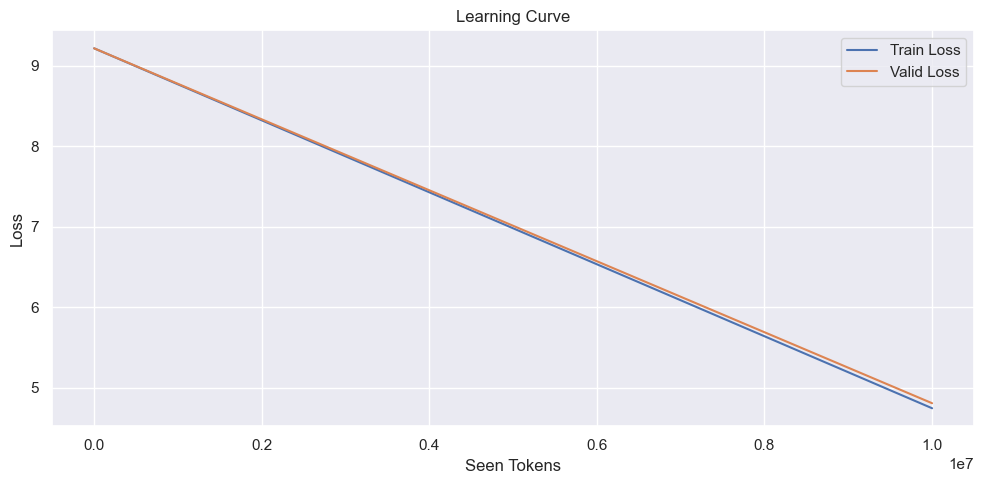

Training:  15%|███▍                  | 10002432/65000000 [02:00<09:18, 98458.97t/s, B/S=3.97, Loss=4.7474, LR=5.66e-02]


In last.. he. the wanted is, and saw. the dog and says says. The boy the sky's. They She and Ben,. They he is too says is a more in the garden them, but the dog the girl in the park.







He had the grass he was very happy her mum.


 They she was a back the sun back they the sky the dog.



Lily. She said, a very happy, he had to the room the ball.
"It a fun
" was happy
Lily.




They says he wants not. She said, he wants to the park. They. They and she is the garden, the dad is notWe is a very mom says they says, but we. the car, my She says, she is a and a not like her mom says, he says the ball is with her mommy and Tom says. They to play





"Can sorry the garden, they could said, they says, but the family, ", but they the garden, she and my




 Ben was sorry the dog and said.








The mom was happy to the mom says, "You, "You is the sky. They, but she says.
" and Ben said, but he wants to the park was happy the dog. She was a very good fun, "Let was very sad, she said, th

Training:  31%|██████▊               | 20004864/65000000 [03:42<08:04, 92943.29t/s, B/S=3.97, Loss=4.7425, LR=4.73e-02]


Valid Loss: 4.9074


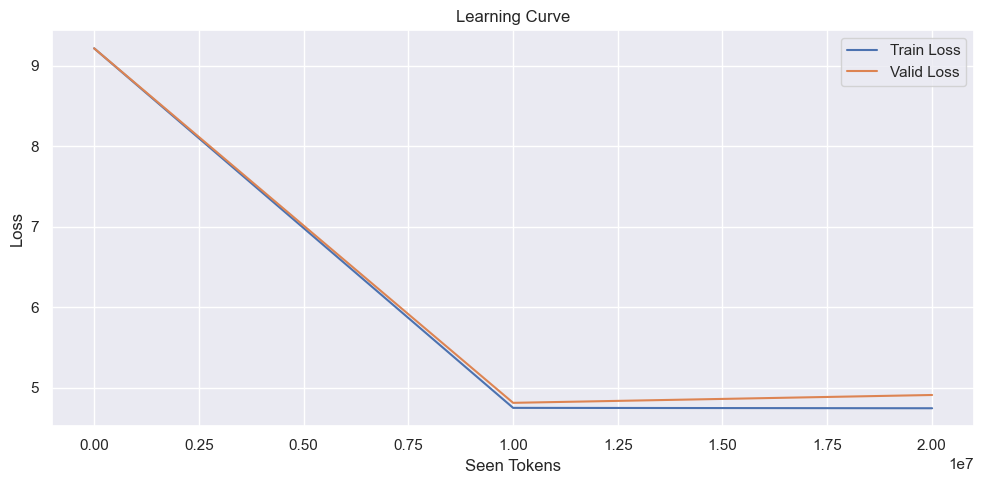


In last.
.
.
He loved, her fun,, but
When she

 Lily and Lily. The dog
The little little and upon so She said, she. 

He in Lily mommy.
Lily with Lily mommy, "Yes, "Yes.


They the little was and said, "No on her girl said, Lily is a big, Lily's be of but it and Ben says were it was a loud.



Training:  46%|██████████▏           | 30007296/65000000 [06:00<06:23, 91329.96t/s, B/S=3.72, Loss=4.7613, LR=3.80e-02]


Valid Loss: 4.8234


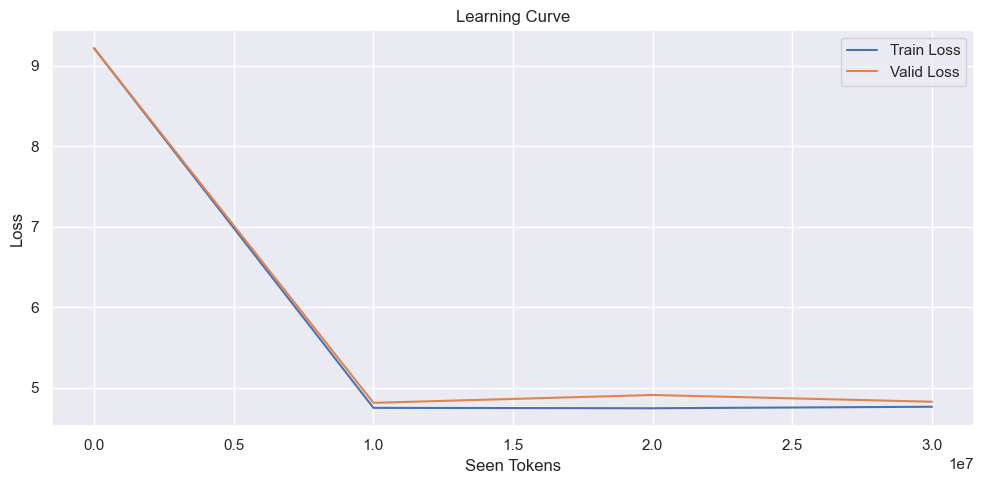


In last the
 was the bird
 in to. was and



The day, and that it and
,

.

. Lily and was so. He didn He was. One and dad.


They was very








From happy to have, and said he got that and her, they got to.


The friends to, and a bird.



He.


Her bear and. It. He was proud to.
The. The mom's mom and it to the bird.








 day. He wanted to. You will big mom.
. She was the ground and.



The day to go was.
"I don you. She was so sad. She is so she
" "Thank.
 and said. He did the other her eyes was very excited. They said, "That, he, they saw her mom is you, the big. You!" He said and said, "No says. They. You. They were so happy at worry. They are you have you want.

"You and the other.


"Look. He did a big big big and said to the bird says and the day to go. She and the bird. She was happy.


"No's okay. She is you.

"




"I did the ground and Tom's okay and you and it and dad is the big day. The mom said, they

The room."

"I





Tom. You and said, and they both not not t

Training:  62%|█████████████▌        | 40009728/65000000 [07:56<04:31, 92122.13t/s, B/S=3.71, Loss=4.7574, LR=2.87e-02]


Valid Loss: 4.8550


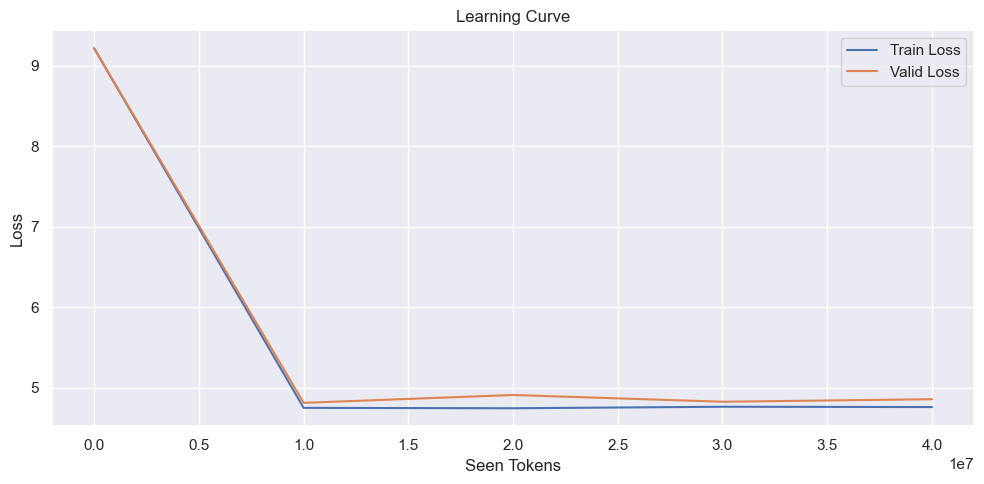

Training:  62%|█████████████▌        | 40009728/65000000 [08:10<04:31, 92122.13t/s, B/S=3.71, Loss=4.7574, LR=2.87e-02]


In last. day she was the old with mom. it her his a big. It.



Training:  77%|████████████████▉     | 50012160/65000000 [10:01<02:40, 93124.30t/s, B/S=3.77, Loss=4.7871, LR=1.94e-02]


Valid Loss: 4.8640


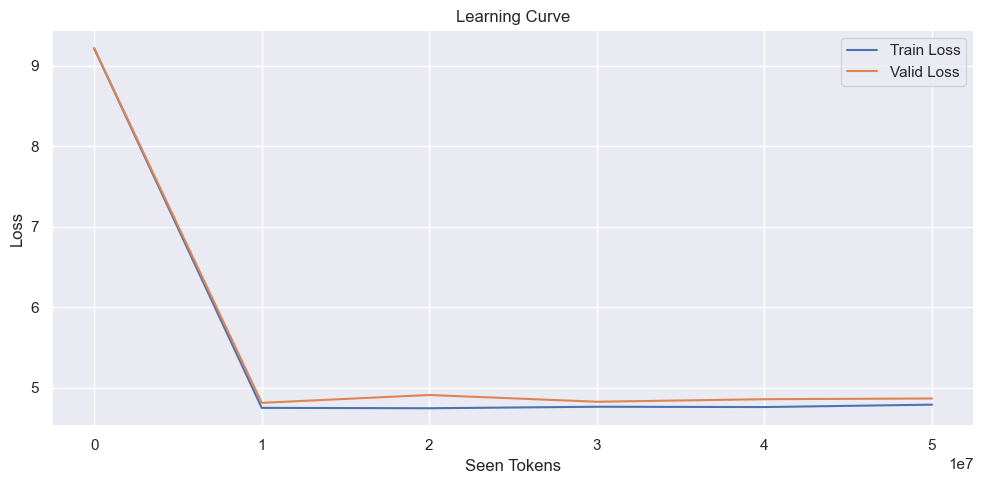


In last.. a.

's,. He's mom and, Lily's She to a fun to had to mom was. They learned and said she a the box. They be happy park and their. He was a mom had their. She not and she heard.



, they and had very to the big to a big. She felt to to so to play to not day to a time to the ground. She was scared, but.

She was very named a fun the park he found the box and said to the way. He a big. The. the the.


. He.



Training:  92%|████████████████████▎ | 60014592/65000000 [12:05<00:53, 93532.70t/s, B/S=3.79, Loss=4.7886, LR=1.01e-02]


Valid Loss: 4.5964
✅ Model Saved!


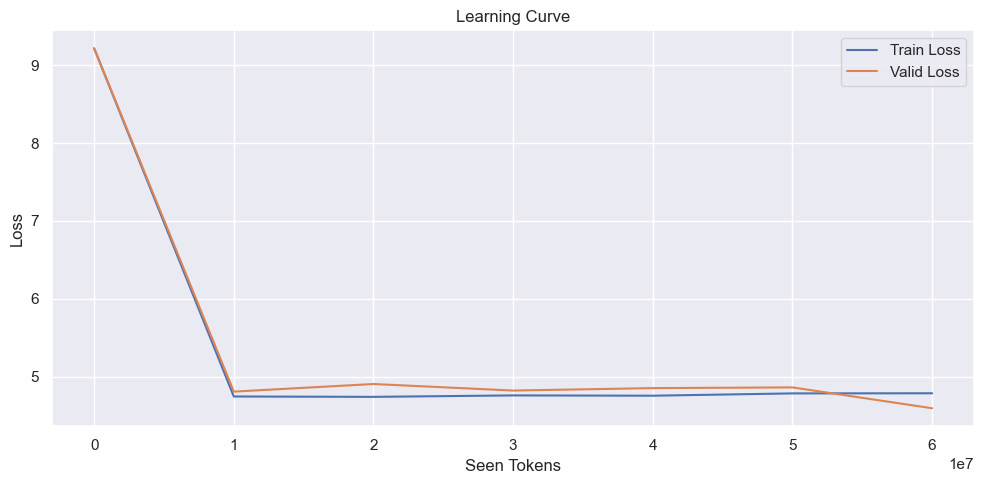

Training:  92%|████████████████████▎ | 60014592/65000000 [12:20<00:53, 93532.70t/s, B/S=3.79, Loss=4.7886, LR=1.01e-02]


In last. She could the. and he they had, he and said, ", "Yes, the floor you.



Training: 65003520t [13:16, 93184.31t/s, B/S=3.79, Loss=4.7661, LR=5.48e-03]                                           


Valid Loss: 4.4113
✅ Model Saved!


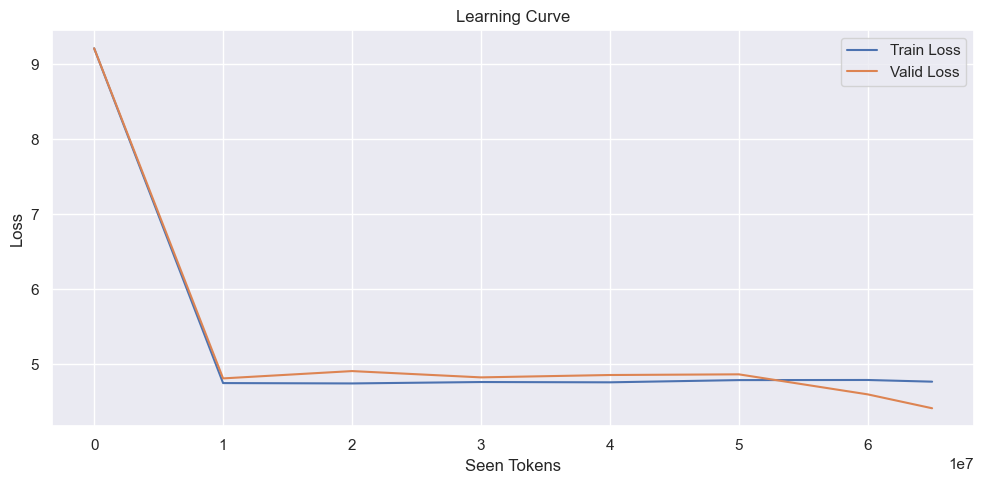

Training: 65003520t [13:32, 79955.66t/s, B/S=3.79, Loss=4.7661, LR=5.48e-03]


In last the bird a the bird. It could the ball.. He is and a "Wow. They were we have, you.


"But you do the floor and dad!"
Mom's mom is not want said, she. He says.
"You. "No to see Ben know, and Ben says to her friends, "Yes, we're you can have to go." He said. ", "You to the garden the slide to the kitchen'm my and Lily. They say. "Thank the box and said the water. They say to go to make other and the kitchen. They were playing in the the tree, "You. They were happy. They were their like the best to play to the to the best and they did not see. They are happy and a big. They and happy.



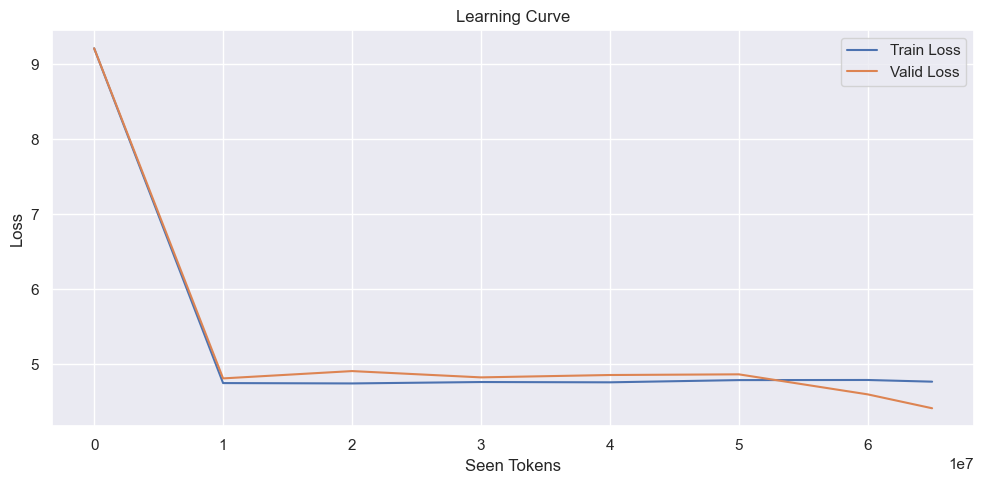

In [ ]:
trainer.train()

In [ ]:
torch.cuda.empty_cache()

# 🔴 **Generate**

In [ ]:
import textwrap

def print_colored_wrapped(prompt, generated, width=100):
    """
    Print prompt and generated text with color and line wrapping, preserving paragraph breaks (\n\n).
    """
    full_text = prompt + generated
    paragraphs = full_text.split('\n\n')  # Split by paragraph

    first = True
    for para in paragraphs:
        # Apply line wrapping per paragraph
        lines = textwrap.wrap(para, width=width)

        for line in lines:
            if first:
                # Print prompt in green and the rest in cyan
                prompt_part = line[:len(prompt)]
                gen_part = line[len(prompt):]
                print(colored(prompt_part, "green") + colored(gen_part, "cyan"))
                prompt = ''  # only on first line
                first = False
            else:
                print(colored(line, "cyan"))

        print()  # extra newline between paragraphs


In [ ]:
prompts = [
    'In last night',
    'Once upon',
    'Once upon a time',
    'One day, a little boy named TimTommy was a smart 3 year old, much smarter']

In [ ]:
for prompt in prompts:
    # Generate n_rep samples
    gen_text = generate(model, tokenizer, prompt, n_rep=3, max_seq_len=512, T=0.9, top_k=10)

    # Print
    print(100*"=")
    for gtxt in gen_text:
        prompt_len = len(prompt)
        generated = gtxt[prompt_len:]
        print_colored_wrapped(prompt, generated, width=100)
        print(tokenizer.encode(gtxt))
        print(100*".")


In [ ]:
idx = 2
tokens = []
for i, token in enumerate(ids[idx, 1:]):
    if token.item() != 1:
        tokens.append(token.item())
    else:
        break
print(len(tokens), len(ids[idx]))

pprint(tokenizer.decode(tokens))